In [72]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import category_encoders as ce
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

pd.set_option('display.max_columns', None)

In [97]:
DATA_PATH = '/home/isds/이민구/Kaggle/American_Express/data/'
SUBMIT_PATH = '/home/isds/이민구/doc/American_Express/submit/'

In [98]:
sub = pd.read_csv(f'{DATA_PATH}submission.csv')
sub.head()

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0


D_* = 연체

S_* = 지출

P_* = 지급

B_* = 잔고

R_* = 위험

In [10]:
train = pd.read_feather(f'{DATA_PATH}train_data.ftr')
test = pd.read_feather(f'{DATA_PATH}test_data.ftr')

display(train.head())
display(test.head())

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827,0


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-02-19,0.631348,0.001912,0.010727,0.814453,0.007545,0.168701,0.009972,0.002348,...,NaN,NaN,NaN,NaN,0.004669,NaN,NaN,NaN,0.008278,NaN
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-03-25,0.586914,0.005276,0.011024,0.811035,0.001817,0.241333,0.000166,0.009132,...,NaN,NaN,NaN,0.000142,0.004940,0.009018,NaN,0.003695,0.003754,0.001460
2,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-04-25,0.608887,0.003326,0.016388,1.004883,0.000114,0.267090,0.004196,0.004192,...,NaN,NaN,NaN,0.000074,0.002113,0.004658,NaN,0.003155,0.002155,0.006481
3,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-05-20,0.614746,0.009064,0.021667,0.816406,0.009720,0.188965,0.004124,0.015327,...,NaN,NaN,NaN,0.004742,0.006393,0.002890,NaN,0.006042,0.005207,0.007858
4,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-06-15,0.591797,0.238770,0.015930,0.810547,0.002026,0.180054,0.000731,0.011284,...,NaN,NaN,NaN,0.008133,0.004330,0.008385,NaN,0.001008,0.007420,0.009468


In [73]:
def compute_recall_at4(y_true: np.array, y_pred: np.array) -> float:
    
    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos
    
    # desc sorting by prediction values
    indices = np.argsort(y_pred)[::-1]
    target = y_true[indices]
    
    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_mask = cum_norm_weight <= 0.04
    
    # default rate captured at 4%
    d = target[four_pct_mask].sum() / n_pos
    
    return d

def compute_normalized_gini(y_true: np.array, y_pred: np.array) -> float:
    
    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos

    # sorting desc by prediction values
    indices = np.argsort(y_pred)[::-1]
    target = y_true[indices]

    # weighted gini coefficient
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()

    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max
    
    return g
    
def compute_amex_metric(y_true: np.array, y_pred: np.array) -> float:

    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos

    # sorting desc by prediction values
    indices = np.argsort(y_pred)[::-1]
    target = y_true[indices]

    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_filter = cum_norm_weight <= 0.04

    # default rate captured at 4%
    d = target[four_pct_filter].sum() / n_pos

    # weighted gini coefficient
    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max

    return 0.5 * (g + d)

In [74]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [12]:
#ID별로 날짜순으로 데이터 정렬 후 중복 제거
train = (
    train
    .sort_values(["customer_ID","S_2"], ascending=[True,False])
    .drop_duplicates(subset=["customer_ID"], keep="first", ignore_index=True)
)

gc.collect()

0

In [13]:
train.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-13,0.934570,0.009117,0.009384,1.007812,0.006104,0.135010,0.001604,0.007175,...,NaN,NaN,0.007187,0.004234,0.005085,NaN,0.005810,0.002970,0.008530,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2018-03-25,0.880371,0.178101,0.034698,1.003906,0.006912,0.165527,0.005550,0.005070,...,NaN,NaN,0.002981,0.007481,0.007874,NaN,0.003284,0.003170,0.008514,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,2018-03-12,0.880859,0.009705,0.004284,0.812500,0.006451,NaN,0.003796,0.007195,...,NaN,NaN,0.007381,0.006622,0.000965,NaN,0.002201,0.000834,0.003445,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,2018-03-29,0.621582,0.001082,0.012566,1.005859,0.007828,0.287842,0.004532,0.009941,...,NaN,NaN,0.002705,0.006184,0.001899,NaN,0.008186,0.005558,0.002983,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,2018-03-30,0.872070,0.005573,0.007679,0.815918,0.001247,NaN,0.000231,0.005527,...,NaN,NaN,0.002974,0.004162,0.005764,NaN,0.008156,0.006943,0.000905,0


In [77]:
input_var = train.iloc[:,2:-1].columns.tolist()
float_var = train.iloc[:,2:].select_dtypes(include = 'float16').columns.tolist()

# target 변수를 제외한 categorical 변수
# ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
cat_var = train.iloc[:,2:].select_dtypes(exclude = 'float16').columns.tolist()[:-1]

len(float_var) + len(cat_var) == len(train.iloc[:,2:-1].columns) #target 변수 제외후 변수 갯수 비교 

## float 아니면 categorical 변수로 이루어져 있음.

True

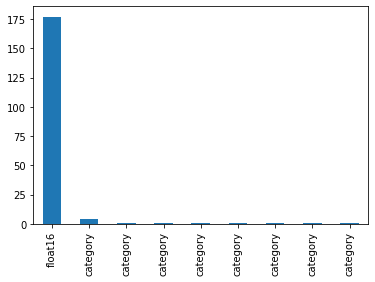

In [51]:
train.iloc[:,2:-1].dtypes.value_counts().plot(kind = 'bar')

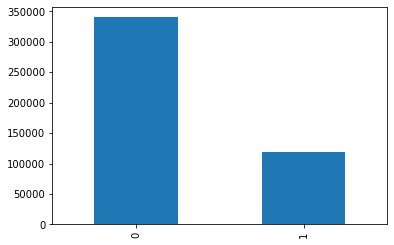

In [55]:
train['target'].value_counts().plot(kind = 'bar')

In [58]:
#불균형 데이터니까 stratified kfold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf_split = list(skf.split(train, train["target"].values)) # 쪼개고 난 후의 index가 담겨져있음

In [62]:
print(len(skf_split[0][0])) # 학습
print(len(skf_split[0][1])) # 검증

367130
91783


In [83]:
model_params = {
    'objective': 'binary',
    'metric': 'None',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'force_col_wise': True,
    'seed': 42,
    'verbosity': 0,
    'first_metric_only': True,
}

######################################## training model 1/5 ########################################
Training until validation scores don't improve for 50 rounds
[50]	valid_0's amex_metric: 0.769481	valid_0's recall_at4: 0.628882	valid_0's norm_gini: 0.910081
[100]	valid_0's amex_metric: 0.781716	valid_0's recall_at4: 0.646764	valid_0's norm_gini: 0.916667
[150]	valid_0's amex_metric: 0.785408	valid_0's recall_at4: 0.651351	valid_0's norm_gini: 0.919466
[200]	valid_0's amex_metric: 0.789054	valid_0's recall_at4: 0.657368	valid_0's norm_gini: 0.920741
[250]	valid_0's amex_metric: 0.789529	valid_0's recall_at4: 0.657957	valid_0's norm_gini: 0.921101
[300]	valid_0's amex_metric: 0.79006	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.921237
[350]	valid_0's amex_metric: 0.790706	valid_0's recall_at4: 0.660145	valid_0's norm_gini: 0.921267
[400]	valid_0's amex_metric: 0.789964	valid_0's recall_at4: 0.658546	valid_0's norm_gini: 0.921382
Early stopping, best iteration is:
[372]	valid_0

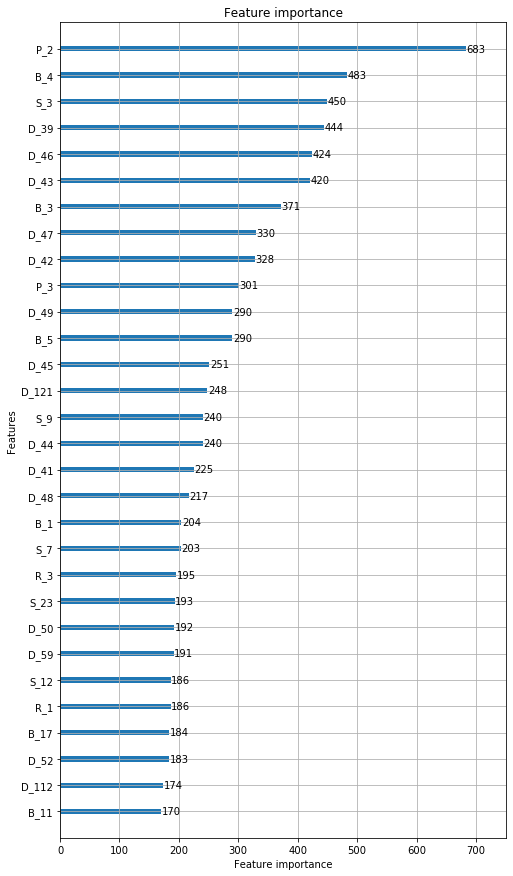

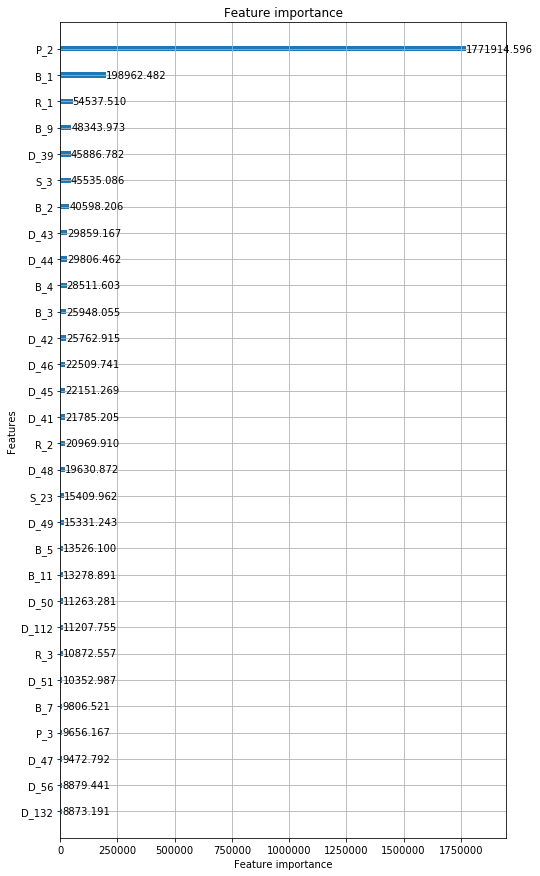

######################################## training model 2/5 ########################################
Training until validation scores don't improve for 50 rounds
[50]	valid_0's amex_metric: 0.762617	valid_0's recall_at4: 0.616974	valid_0's norm_gini: 0.908261
[100]	valid_0's amex_metric: 0.774229	valid_0's recall_at4: 0.633889	valid_0's norm_gini: 0.914569
[150]	valid_0's amex_metric: 0.778826	valid_0's recall_at4: 0.640495	valid_0's norm_gini: 0.917158
[200]	valid_0's amex_metric: 0.78029	valid_0's recall_at4: 0.64243	valid_0's norm_gini: 0.91815
[250]	valid_0's amex_metric: 0.781283	valid_0's recall_at4: 0.644029	valid_0's norm_gini: 0.918536
[300]	valid_0's amex_metric: 0.781518	valid_0's recall_at4: 0.644366	valid_0's norm_gini: 0.918669
Early stopping, best iteration is:
[284]	valid_0's amex_metric: 0.782028	valid_0's recall_at4: 0.645418	valid_0's norm_gini: 0.918638


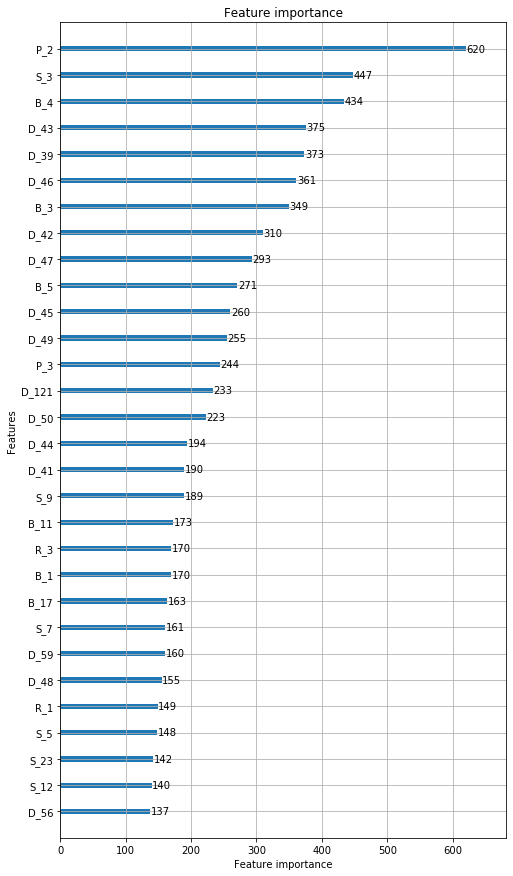

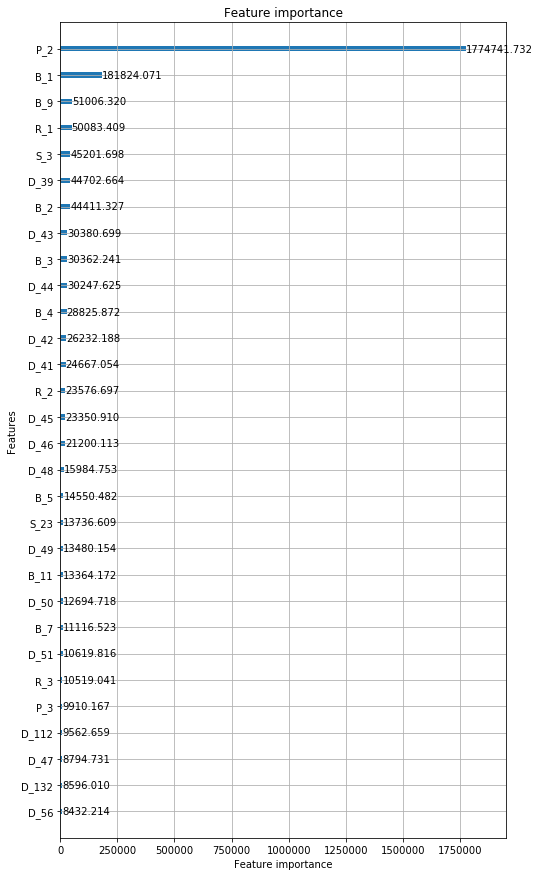

######################################## training model 3/5 ########################################
Training until validation scores don't improve for 50 rounds
[50]	valid_0's amex_metric: 0.766116	valid_0's recall_at4: 0.624295	valid_0's norm_gini: 0.907936
[100]	valid_0's amex_metric: 0.778846	valid_0's recall_at4: 0.642725	valid_0's norm_gini: 0.914967
[150]	valid_0's amex_metric: 0.783198	valid_0's recall_at4: 0.648658	valid_0's norm_gini: 0.917738
[200]	valid_0's amex_metric: 0.785726	valid_0's recall_at4: 0.652613	valid_0's norm_gini: 0.918839
[250]	valid_0's amex_metric: 0.785538	valid_0's recall_at4: 0.65194	valid_0's norm_gini: 0.919137
[300]	valid_0's amex_metric: 0.785233	valid_0's recall_at4: 0.651224	valid_0's norm_gini: 0.919241
Early stopping, best iteration is:
[256]	valid_0's amex_metric: 0.786177	valid_0's recall_at4: 0.653202	valid_0's norm_gini: 0.919151


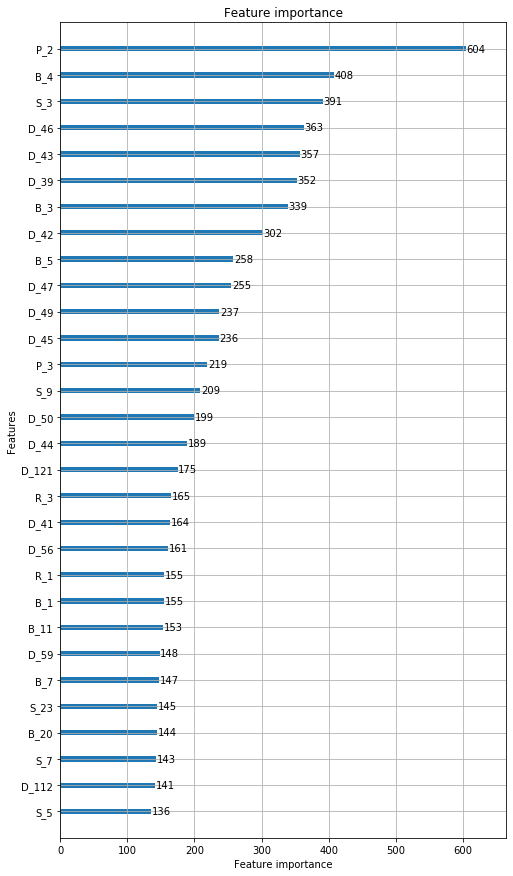

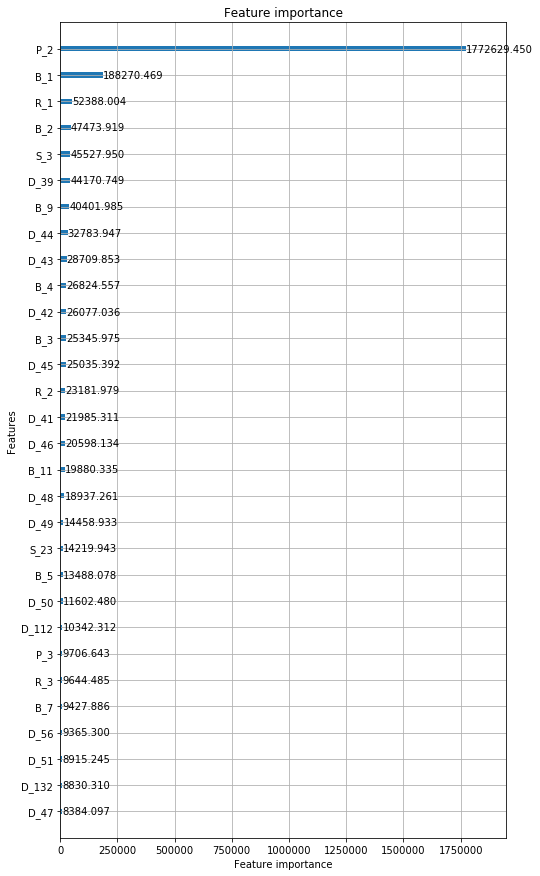

######################################## training model 4/5 ########################################
Training until validation scores don't improve for 50 rounds
[50]	valid_0's amex_metric: 0.759588	valid_0's recall_at4: 0.612792	valid_0's norm_gini: 0.906384
[100]	valid_0's amex_metric: 0.773528	valid_0's recall_at4: 0.633621	valid_0's norm_gini: 0.913436
[150]	valid_0's amex_metric: 0.777582	valid_0's recall_at4: 0.638628	valid_0's norm_gini: 0.916536
[200]	valid_0's amex_metric: 0.779052	valid_0's recall_at4: 0.640396	valid_0's norm_gini: 0.917709
[250]	valid_0's amex_metric: 0.779825	valid_0's recall_at4: 0.641532	valid_0's norm_gini: 0.918118
[300]	valid_0's amex_metric: 0.780443	valid_0's recall_at4: 0.642626	valid_0's norm_gini: 0.918261
[350]	valid_0's amex_metric: 0.780582	valid_0's recall_at4: 0.642878	valid_0's norm_gini: 0.918286
Early stopping, best iteration is:
[323]	valid_0's amex_metric: 0.781215	valid_0's recall_at4: 0.644141	valid_0's norm_gini: 0.918289


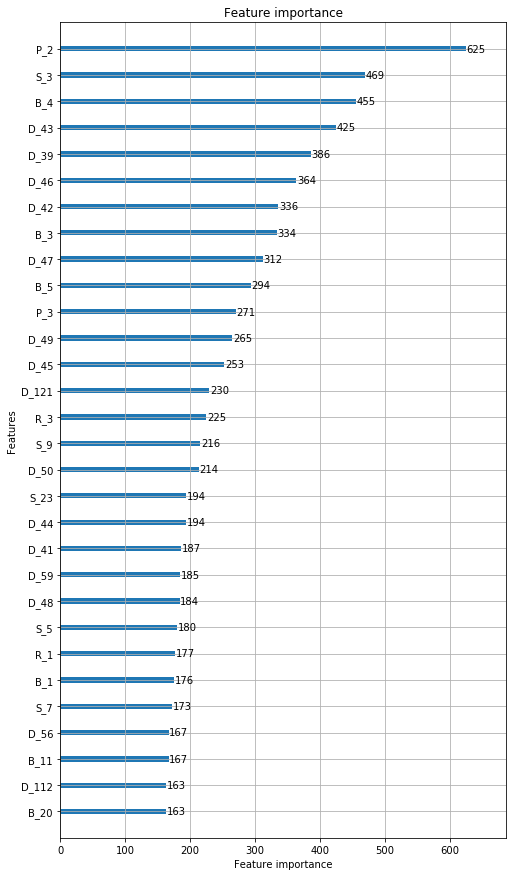

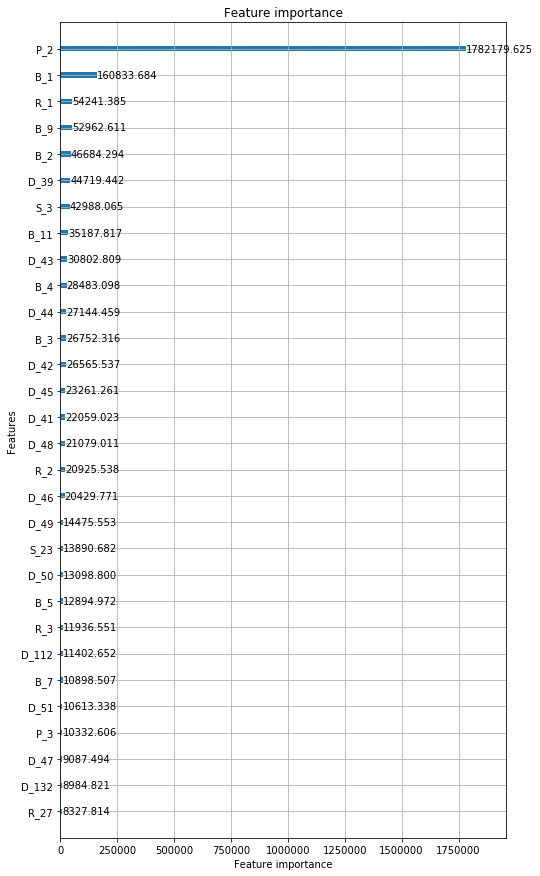

######################################## training model 5/5 ########################################
Training until validation scores don't improve for 50 rounds
[50]	valid_0's amex_metric: 0.766034	valid_0's recall_at4: 0.623059	valid_0's norm_gini: 0.909008
[100]	valid_0's amex_metric: 0.777172	valid_0's recall_at4: 0.638418	valid_0's norm_gini: 0.915926
[150]	valid_0's amex_metric: 0.782478	valid_0's recall_at4: 0.646244	valid_0's norm_gini: 0.918712
[200]	valid_0's amex_metric: 0.785177	valid_0's recall_at4: 0.650494	valid_0's norm_gini: 0.91986
[250]	valid_0's amex_metric: 0.786385	valid_0's recall_at4: 0.652472	valid_0's norm_gini: 0.920299
[300]	valid_0's amex_metric: 0.786873	valid_0's recall_at4: 0.653482	valid_0's norm_gini: 0.920263
Early stopping, best iteration is:
[255]	valid_0's amex_metric: 0.786642	valid_0's recall_at4: 0.652977	valid_0's norm_gini: 0.920307


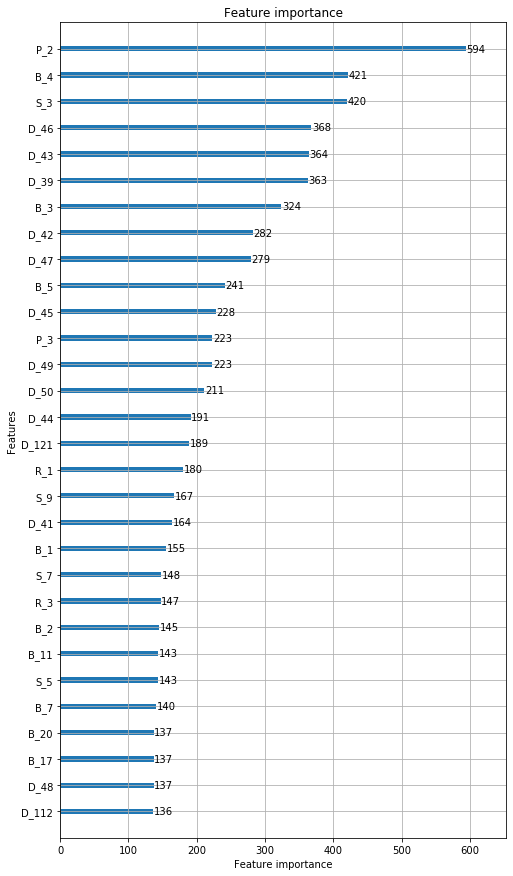

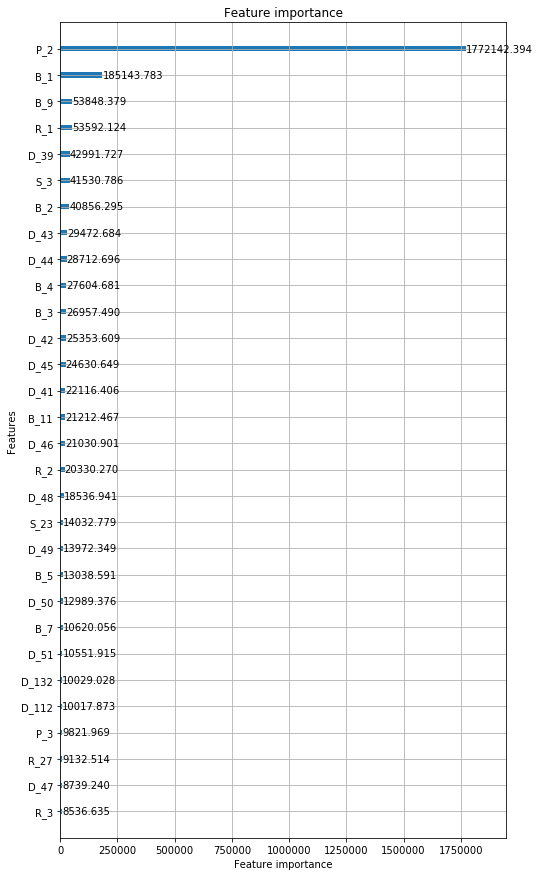

CPU times: user 40min 47s, sys: 34.4 s, total: 41min 21s
Wall time: 2min 15s


In [87]:
%%time
models = list()

# dataframe to store the oof predictions
y = train[["target"]].copy()
y["pred"] = -1

for fold,(train_idx,valid_idx) in enumerate(skf_split):
    
    print(f" training model {fold+1}/{len(skf_split)} ".center(100, "#"))
    
    train_df = lgb.Dataset(
        data=train.loc[train_idx,input_var],
        label=train.loc[train_idx,"target"].values,
        categorical_feature=cat_var,
        free_raw_data=True
    )
    valid_df = lgb.Dataset(
        data=train.loc[valid_idx,input_var],
        label=train.loc[valid_idx,"target"].values,
        categorical_feature=cat_var,
        free_raw_data=True
    )
    
    model = lgb.train(
        params=model_params,
        train_set=train_df,
        valid_sets=[valid_df,],
        feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
        num_boost_round=3000,
        callbacks=[lgb.log_evaluation(period=50), lgb.early_stopping(50)],
    )
    
    lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
    lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
    plt.show()
    
    y.loc[valid_idx,"pred"] = model.predict(train.loc[valid_idx,input_var])
    
    models.append(model)
    del train_df,valid_df
    gc.collect()

In [88]:
# evaluation metrics
print("recall_at4:", compute_recall_at4(labels.target.values, labels.pred.values))
print("normalized_gini:", compute_normalized_gini(labels.target.values, labels.pred.values))
print("competition metric:", compute_amex_metric(labels.target.values, labels.pred.values))

recall_at4: 0.6496869424714714
normalized_gini: 0.9187992848071721
competition metric: 0.7842431136393218


In [89]:
# test data
test = (
    test
    .sort_values(["customer_ID","S_2"], ascending=[True,False])
    .drop_duplicates(subset=["customer_ID"], keep="first", ignore_index=True)
)

gc.collect()

0

In [90]:
test.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-10-12,0.568848,0.121399,0.010780,1.009766,0.006924,0.149414,0.000396,0.003576,0.10376,0.007397,0.006786,0.124756,0.025116,0.050201,0.007511,0.445801,0.489502,0.517090,NaN,0.024948,0.163452,1.008789,NaN,0.333496,0.005264,0.109436,0.115906,0.560547,0.033600,NaN,0.011795,0.005188,0.003473,1.007812,0.005608,0.159668,0.058685,0.464111,0.458496,NaN,0.063477,0.005444,0.381348,0.016998,0.008621,0.424561,0.013832,0.589355,0.014091,1.767578,0.049316,CR,U,0.001363,0.002310,NaN,0.590332,0.003994,NaN,0.004524,6.0,0.187622,0.002590,0.555664,0.006618,0.008133,0.007282,0.006584,0.281494,0.008804,0.300537,0.147217,0.178833,0.964844,0.216553,0.202148,NaN,0.007061,0.005943,NaN,0.005402,0.009331,0.001974,0.008972,0.008865,NaN,0.009270,0.006065,0.007290,0.003654,0.000554,0.000375,0.502930,0.007408,1.006836,0.140015,0.007858,0.007446,0.006870,0.001841,0.003838,0.000871,0.002720,0.0,0.009056,0.009209,NaN,0.005638,0.005024,NaN,1.0,0.003336,0.004120,0.007153,0.005337,0.004211,0.007244,1.007812,0.008675,0.000612,0.003235,0.003138,1.005859,0.005646,0.000724,0.008163,0.005955,0.004623,0.979980,0.135742,0.957520,0.970703,0.080566,0.003998,0.003952,0.006016,NaN,NaN,0.000153,0.001118,0.007950,NaN,1.001953,2.0,NaN,0.000151,NaN,NaN,NaN,1.006836,0.375488,0.346436,0.009605,0.0,0.251221,0.0,-1.0,0.247314,0.253662,1.0,0.199219,0.144043,0.004272,0.009895,0.000478,0.0,0.009689,0.001736,0.009964,0.006790,NaN,0.004902,0.000975,NaN,0.006271,0.008820,NaN,NaN,NaN,NaN,NaN,0.005913,0.001250,0.006542,NaN,0.009163,0.003691,0.003220
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,2019-04-15,0.841309,0.126465,0.016556,1.008789,0.009712,0.112183,0.006191,0.011383,NaN,NaN,0.004234,0.014832,0.099731,0.135864,0.002270,0.446045,0.362305,0.041718,NaN,0.182739,0.014465,1.008789,NaN,0.001505,0.017456,0.008148,0.144043,0.525879,0.298828,NaN,0.009338,0.002235,0.005253,1.002930,0.008385,0.081726,0.054199,0.768555,0.053436,0.063782,0.058594,0.004131,0.006374,0.018509,0.010849,0.608887,0.685547,0.046722,0.005459,0.128296,0.330811,CO,O,0.000348,0.091125,NaN,1.004883,0.003038,NaN,0.000821,6.0,0.190674,0.009712,0.283936,0.004333,0.001395,0.001878,0.003786,0.010399,0.007236,0.107483,0.004757,NaN,0.005310,0.001835,0.004974,NaN,0.008171,0.006783,0.302246,0.026566,0.005947,0.004501,0.003979,0.001245,NaN,0.005310,0.001574,0.005653,0.000168,0.000172,0.005024,NaN,0.002403,1.003906,0.008614,0.005524,0.007568,0.005802,0.004482,0.005302,0.002537,NaN,0.0,0.009163,0.004242,NaN,0.003904,0.007187,NaN,1.0,0.008255,0.004913,0.007183,0.002151,0.002085,0.002205,1.004883,0.007065,0.001214,0.006069,0.005062,0.006802,0.004040,0.001636,0.005405,0.000980,0.009926,0.928711,0.135620,0.939453,0.974609,0.020569,0.007385,0.006145,0.004749,NaN,NaN,0.002687,0.007423,0.012894,NaN,1.000977,2.0,NaN,0.006355,NaN,NaN,NaN,1.003906,0.005497,0.590820,0.000566,1.0,0.317383,0.0,3.0,0.316650,0.318115,0.0,0.854980,0.578613,0.000412,0.645508,0.005066,1.0,0.009552,0.999512,0.001249,0.007339,NaN,0.001252,0.007633,NaN,0.0

In [107]:
%%time
preds = [model.predict(test[input_var]) for model in models]
test["prediction"] = np.mean(preds, axis=0)

CPU times: user 2min 18s, sys: 2.82 s, total: 2min 21s
Wall time: 15.1 s


In [108]:
submission = pd.merge(sub[["customer_ID"]], test[["customer_ID","prediction"]]) # 제출은 확률값을 내야함.
submission.head()

,customer_ID,pred
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.031785
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.001871
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.032642
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.277229
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.890773


In [112]:
assert submission.predictions.isna().sum() == 0

In [114]:
submission.to_csv(f"{SUBMIT_PATH}lgbm_test1.csv", index=False)